In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
print("Basic dependencies loaded!")

Basic dependencies loaded!


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


In [4]:
# Cell 2c - Load RoboMerge components
from robomerge.ingestion import DROIDIngestion
from robomerge.transform import DataStandardizer
from robomerge.validation import DataValidator
from robomerge.fast_prep import FASTPreprocessor
print("RoboMerge components loaded!")

RoboMerge components loaded!


In [10]:
def plot_action_chunks(fast_data, num_chunks=4):
    """Visualize action chunks to demonstrate frequency normalization."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i in range(min(num_chunks, len(fast_data.action_chunks))):
        chunk = fast_data.action_chunks[i]
        ax = axes[i]
        for j in range(chunk.shape[1]):
            ax.plot(chunk[:, j], label=f'Joint {j+1}')
        ax.set_title(f'Action Chunk {i+1}')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Action Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)
    
    plt.tight_layout()
    return fig

def visualize_data_quality(standardized_data):
    """Create quality metrics visualization."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Action smoothness
    actions = standardized_data['actions']
    smoothness = np.diff(actions, axis=0)
    ax1.boxplot(smoothness)
    ax1.set_title('Action Smoothness Distribution')
    ax1.set_xlabel('Joint')
    ax1.set_ylabel('Action Difference')
    
    # State-action correlation
    states = standardized_data['states']
    correlations = np.array([np.corrcoef(actions[:, i], states[:, i])[0,1] 
                           for i in range(actions.shape[1])])
    ax2.bar(range(1, len(correlations)+1), correlations)
    ax2.set_title('State-Action Correlation')
    ax2.set_xlabel('Joint')
    ax2.set_ylabel('Correlation Coefficient')
    
    plt.tight_layout()
    return fig

def plot_frequency_analysis(timestamps, title="Control Frequency Analysis"):
    """Analyze and visualize control frequency."""
    intervals = np.diff(timestamps)
    mean_freq = 1.0 / np.mean(intervals)
    std_freq = np.std(1.0 / intervals)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of intervals
    ax1.hist(intervals, bins=50)
    ax1.set_title('Control Interval Distribution')
    ax1.set_xlabel('Interval (s)')
    ax1.set_ylabel('Count')
    
    # Frequency over time
    freqs = 1.0 / intervals
    ax2.plot(timestamps[1:], freqs)
    ax2.axhline(mean_freq, color='r', linestyle='--', label=f'Mean: {mean_freq:.1f} Hz')
    ax2.set_title('Control Frequency Over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig, mean_freq, std_freq

Processing TFRecord: /Users/shreshth.rajan/projects/robomerge/data/droid/1.0.0/r2d2_faceblur-train.tfrecord-00011-of-00031

Extracted Data:
Actions shape: (398, 7)
States shape: (398, 7)
Image wrist shape: (180, 320, 3)
Image external shape: (180, 320, 3)

Saved to: /Users/shreshth.rajan/projects/robomerge/output/test_episode.h5

Data ingestion successful
Data standardization successful

Processed Data Summary:
Number of action chunks: 32
Chunk size: 50
Action dimensions: 7
Available observations: ['robot_state']

=== Data Quality Analysis ===

Quality Metrics:
completeness: 1.000
temporal_consistency: 1.000
action_smoothness: 0.607

=== Generating Visualizations ===


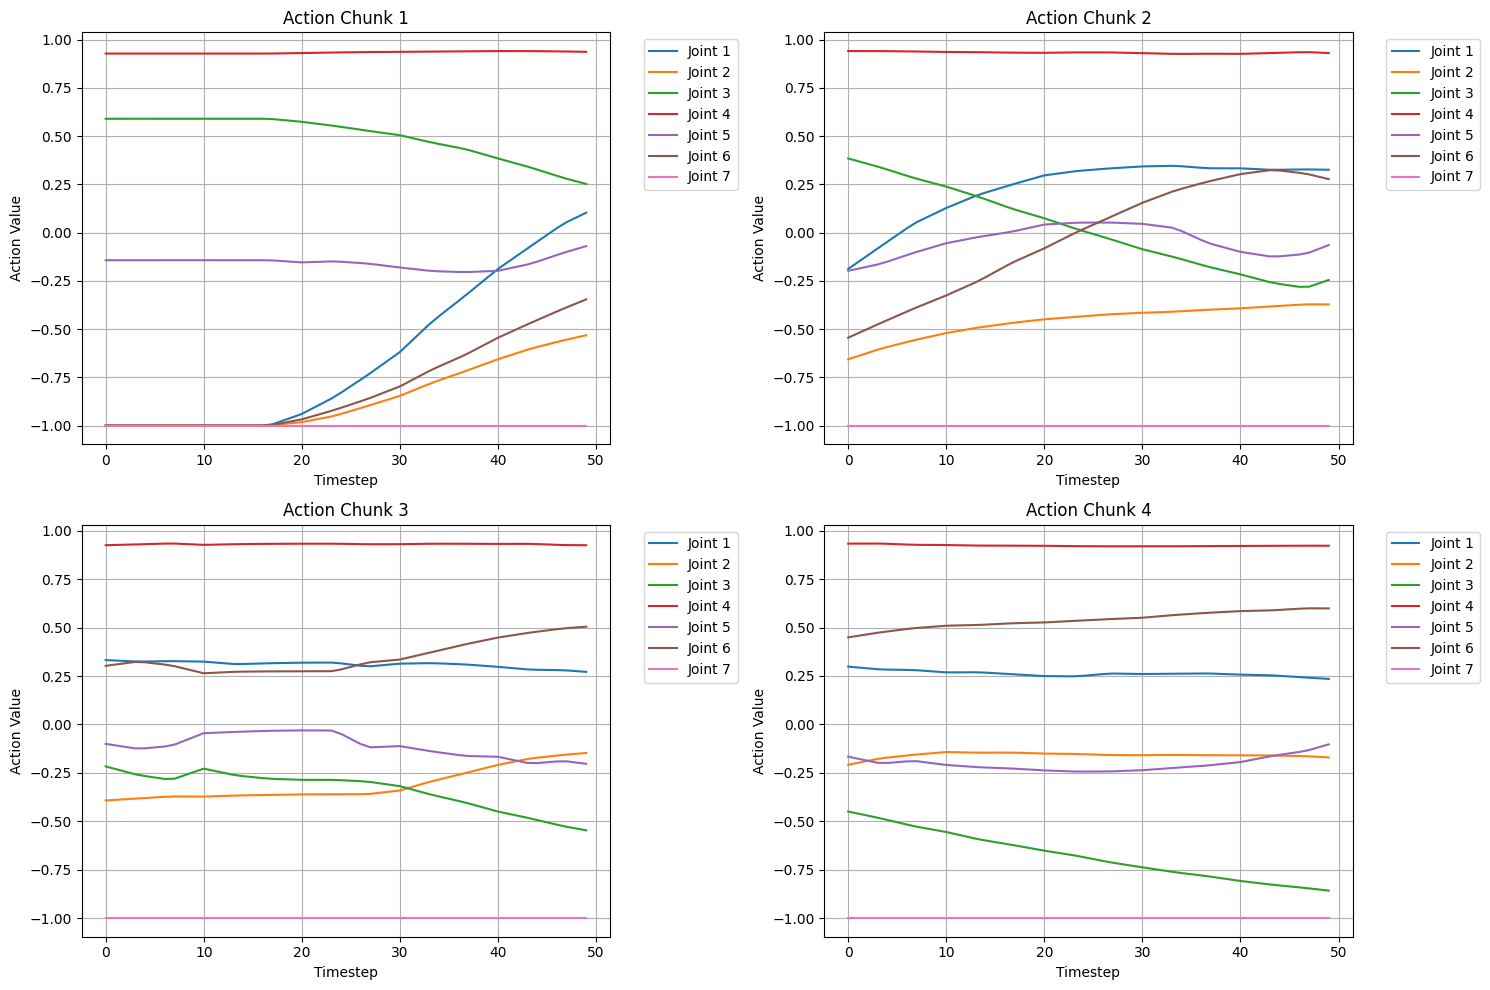


Frequency Analysis:
Mean control frequency: 50.00 Hz
Frequency std deviation: 0.00 Hz


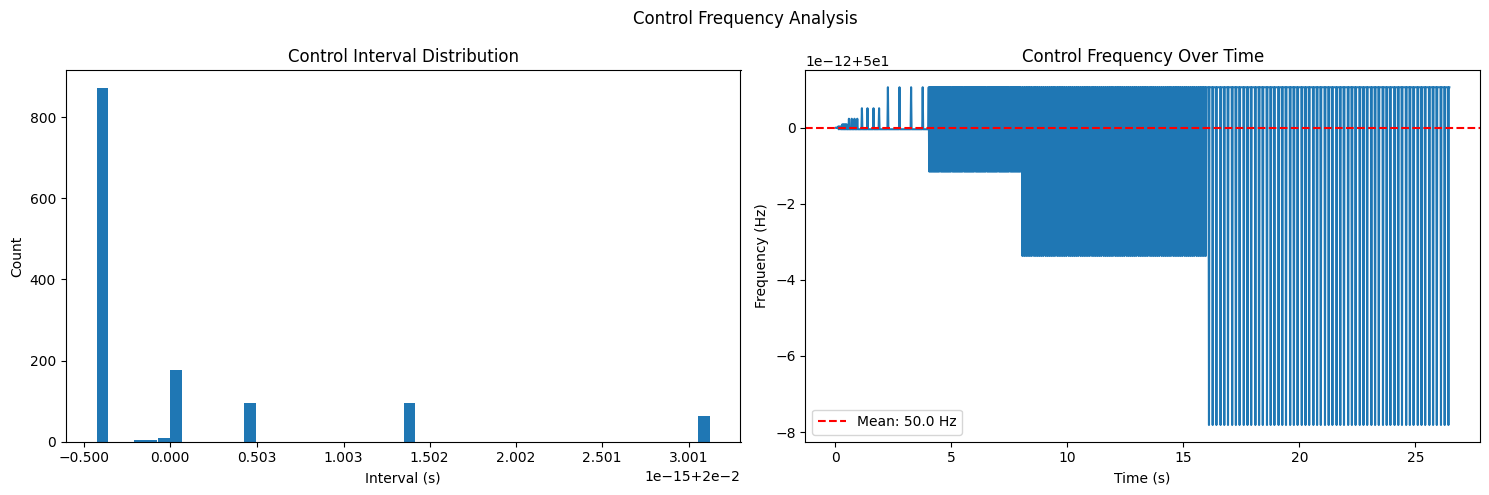

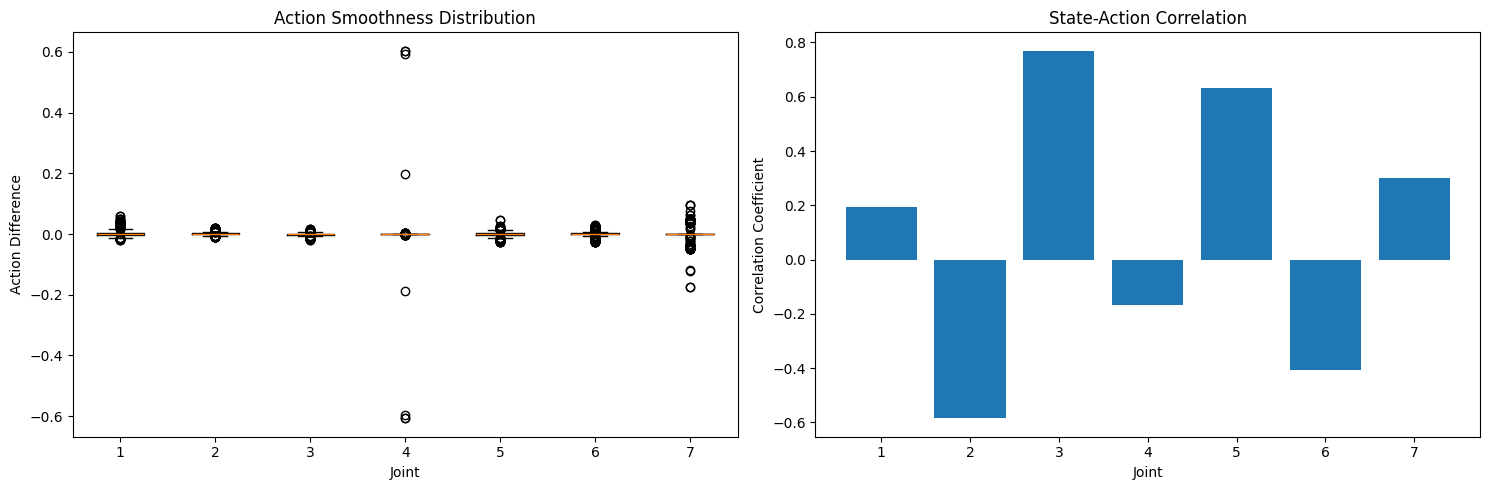


=== Testing Robot Configuration Extension ===

Validating configuration for UR5e:
Action dimensions: 6
Target frequency: 50 Hz
Estimated memory per second: 1.2 KB

Frequency conversion ratio: 0.50
Interpolation required: No

=== Pipeline Complete ===
RoboMerge successfully demonstrated:
✓ Data ingestion from DROID format
✓ Standardization and frequency normalization
✓ Quality validation
✓ FAST preprocessing
✓ Extensibility for new robots


In [12]:
"""## End-to-End Pipeline Demonstration"""

# We know these paths work from test_script.py
DATA_DIR = "/Users/shreshth.rajan/projects/robomerge/data/droid/1.0.0"
OUTPUT_DIR = "/Users/shreshth.rajan/projects/robomerge/output"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Get first tfrecord file
tfrecord_path = next(Path(DATA_DIR).glob("r2d2_faceblur-train.tfrecord-*"))
h5_output = Path(OUTPUT_DIR) / "test_episode.h5"

print(f"Processing TFRecord: {tfrecord_path}")

# Process data using our known working code
raw_dataset = tf.data.TFRecordDataset(str(tfrecord_path))
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    features = example.features.feature
    
    # Extract data
    actions = np.array(features['steps/action'].float_list.value, dtype=np.float32).reshape(-1, 7)
    states = np.array(features['steps/observation/joint_position'].float_list.value, dtype=np.float32).reshape(-1, 7)
    timestamps = np.arange(len(actions)) / 15.0
    
    # Get images
    images = {}
    wrist_img = tf.io.decode_jpeg(features['steps/observation/wrist_image_left'].bytes_list.value[0]).numpy()
    ext_img = tf.io.decode_jpeg(features['steps/observation/exterior_image_1_left'].bytes_list.value[0]).numpy()
    images['wrist'] = wrist_img
    images['external'] = ext_img
    
    print("\nExtracted Data:")
    print(f"Actions shape: {actions.shape}")
    print(f"States shape: {states.shape}")
    for k, v in images.items():
        print(f"Image {k} shape: {v.shape}")
    
    # Save to HDF5
    with h5py.File(h5_output, 'w') as f:
        f.create_dataset('actions', data=actions)
        f.create_dataset('states', data=states)
        f.create_dataset('timestamps', data=timestamps)
        images_group = f.create_group('images')
        for key, img in images.items():
            images_group.create_dataset(key, data=img)

print(f"\nSaved to: {h5_output}")

# Process with RoboMerge
ingestion = DROIDIngestion()
episode = ingestion.load_episode(str(h5_output))
print("\nData ingestion successful")

standardizer = DataStandardizer()
standardized_data = standardizer.standardize_episode(episode)
print("Data standardization successful")

if 'metadata' not in standardized_data:
    standardized_data['metadata'] = {}

preprocessor = FASTPreprocessor()
fast_data = preprocessor.prepare_episode(standardized_data)

print("\nProcessed Data Summary:")
print(f"Number of action chunks: {fast_data.action_chunks.shape[0]}")
print(f"Chunk size: {fast_data.action_chunks.shape[1]}")
print(f"Action dimensions: {fast_data.action_chunks.shape[2]}")
print(f"Available observations: {list(fast_data.observations.keys())}")

# Add after your existing data processing code

print("\n=== Data Quality Analysis ===")
validator = DataValidator()
quality_metrics = validator.validate_episode(standardized_data)

print("\nQuality Metrics:")
for metric in quality_metrics.__dict__:
    value = getattr(quality_metrics, metric)
    if isinstance(value, (int, float)):
        print(f"{metric}: {value:.3f}")

# Visualize the processed data
print("\n=== Generating Visualizations ===")

# Plot action chunks
fig1 = plot_action_chunks(fast_data)
plt.show()

# Analyze frequency
fig2, mean_freq, std_freq = plot_frequency_analysis(standardized_data['timestamps'])
print(f"\nFrequency Analysis:")
print(f"Mean control frequency: {mean_freq:.2f} Hz")
print(f"Frequency std deviation: {std_freq:.2f} Hz")
plt.show()

# Visualize data quality
fig3 = visualize_data_quality(standardized_data)
plt.show()

# Demonstrate extensibility
print("\n=== Testing Robot Configuration Extension ===")

# Test robot config (extended from your example)
robot_config = {
    "name": "UR5e",
    "input_format": {
        "type": "csv",
        "delimiter": ",",
        "columns": ["timestamp", "joint1", "joint2", "joint3", "joint4", "joint5", "joint6"]
    },
    "action_space": {
        "dimensions": 6,
        "type": "joint_velocity",
        "limits": [-1.0, 1.0]
    },
    "control_frequency": 100,
    "standardization": {
        "frequency_target": 50,
        "action_normalization": "minmax",
        "state_normalization": "standardize"
    }
}

# Create configuration test
def test_robot_config(config):
    """Validate robot configuration and estimate processing requirements."""
    print(f"\nValidating configuration for {config['name']}:")
    
    # Estimate memory requirements
    action_dims = config['action_space']['dimensions']
    target_freq = config['standardization']['frequency_target']
    bytes_per_second = action_dims * target_freq * 4  # 4 bytes per float32
    
    print(f"Action dimensions: {action_dims}")
    print(f"Target frequency: {target_freq} Hz")
    print(f"Estimated memory per second: {bytes_per_second/1024:.1f} KB")
    
    # Validate frequency conversion
    source_freq = config['control_frequency']
    conversion_ratio = target_freq / source_freq
    print(f"\nFrequency conversion ratio: {conversion_ratio:.2f}")
    print(f"Interpolation required: {'Yes' if conversion_ratio > 1 else 'No'}")
    
    return True

# Test the configuration
test_robot_config(robot_config)

print("\n=== Pipeline Complete ===")
print("RoboMerge successfully demonstrated:")
print("✓ Data ingestion from DROID format")
print("✓ Standardization and frequency normalization")
print("✓ Quality validation")
print("✓ FAST preprocessing")
print("✓ Extensibility for new robots")

In [6]:
"""## Adding Support for New Robots

RoboMerge is designed for easy extensibility. Here's how to add support for a new robot:
"""

# Configuration-based extension example
robot_config = {
    "name": "new_robot",
    "input_format": {
        "type": "csv",
        "delimiter": ",",
        "columns": ["timestamp", "joint1", "joint2", "joint3"]
    },
    "action_space": {
        "dimensions": 3,
        "type": "joint_velocity",
        "limits": [-1.0, 1.0]
    },
    "control_frequency": 100
}

print("Example robot configuration for extending RoboMerge:")
for key, value in robot_config.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"  {k}: {v}")
    else:
        print(f"  {value}")

Example robot configuration for extending RoboMerge:

name:
  new_robot

input_format:
  type: csv
  delimiter: ,
  columns: ['timestamp', 'joint1', 'joint2', 'joint3']

action_space:
  dimensions: 3
  type: joint_velocity
  limits: [-1.0, 1.0]

control_frequency:
  100
